## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df1 = pd.read_csv('geo_data_0.csv')
df2 = pd.read_csv('geo_data_1.csv')
df3 = pd.read_csv('geo_data_2.csv')

Данные загружены, проведем исследовательский анализ каждого датасета, построив для этого функцию

In [4]:
'''
Функция выводит первые пять строк каждого датафрейма,
считает описательную статистику и строит хитмапы корреляций
признаков для проверки на мультиколлинеарность
'''
df_list = [df1, df2, df3]

def exploratory(list):
    
    fig,ax = plt.subplots(1, len(list), figsize=(14,5), sharex=True)
    
    for i, name in enumerate(list):
        
        print('Локация', i+1, '\n\n')
        print('Первые пять строк:\n')
        print(name.head(5), '\n')
        print('Описательная статистика:\n')
        print(name.describe(), '\n\n')
        
        ax[i].set_title(f'Локация {(i+1)}')
        sns.heatmap(ax=ax[i], data=name.corr(), annot=True, cbar=False)
        if i == 2:
            sns.heatmap(ax=ax[i], data=name.corr(), annot=True)

        print('------------------------------------------------------------ \n')

Локация 1 


Первые пять строк:

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

Описательная статистика:

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347 


------------------------------------

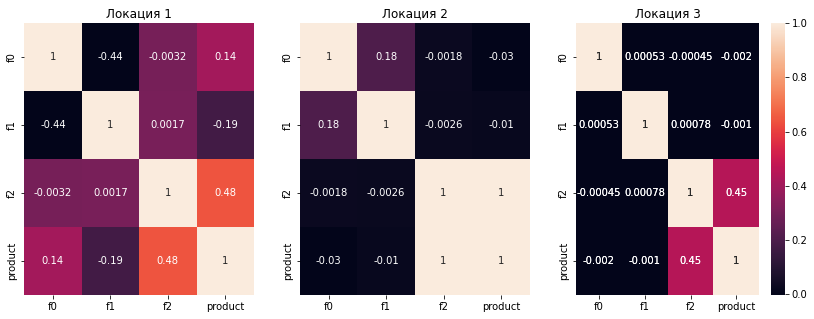

In [5]:
exploratory(df_list)

Первый датасет не содержит пропусков. Проверка на мультиколлинеарность показала наличие линейной зависимости между `f2` и таргетом, а также между `f1` и `f0`, но недостаточно для рассмотрения возможности отбрасывания признака.  

Второй датасет так же не содержит в себе пропуски, при этом мы видим линейную зависимость между `f2` и `product`.

Третий датасет тоже "чистый" и снова признак `f2` показывает линейную зависимость с целевым признаком.

### Выводы

Данные были проверены на наличие артефактов и мультиколлинерность. Масштабирование признаков не требуется. Столбец `id` можно отбросить

## Обучение и проверка модели

Для каждого региона создадим обучающие и валидационные выборки. Обучим модель линейной регрессии и рассчитаем как средний запас предсказанного сырья, так и RMSE модели

Напишем функцию, которая берет датасет и возвращает обучающие и валидационные выборки

In [6]:
'''
Функция принимает датасет, делит его на признаки и таргет,
а их в свою очередь на обучающую и валидационную выборки.
На выходе мы имеем четыре датасета для обучения и валидации +
проверку на длину полученных датасетов
'''
def preprocessing(df):
    
    features = df.drop(['id', 'product'], axis=1)
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=12345)
    
    print('Длина обучающей выборки:', features_train.shape[0])
    print('Длина валидационной выборки:', features_valid.shape[0])
    
    return target, features_train, features_valid, target_train, target_valid

Напишем функцию, которая будет обучать три линейные модели (метод наименьших квадратов, ридж и лассо), с помощью кросс-валидации выбирать лучшую модель по ошибке

In [7]:
'''
Функция принимает четыре датасета, обучает три модели, методом
кросс-валидации на валидационном датасете оценивает метрику R2
модели, возвращает лучшую модель и предикты в формате Series
'''
def regression_train_and_score(features_train, features_valid, target_train, target_valid):
    
    regres = LinearRegression().fit(features_train, target_train)
    ridge = Ridge().fit(features_train, target_train)
    lasso = Lasso().fit(features_train, target_train)
    
    model_list = [regres, ridge, lasso]
    best_model = None
    best_r2_score = 0
    best_rmse = 1000
    prediction = None
    
    for i, name in enumerate(model_list):
        
        predictions = name.predict(features_valid)
        
        r2_score = np.mean(cross_val_score(name, features_valid, target_valid, scoring='r2'))
        neg_mse = cross_val_score(name, features_valid, target_valid, scoring='neg_mean_squared_error')
        rmse = np.mean(np.sqrt(-neg_mse))
        
        if rmse <  best_rmse:
            
            best_model = name
            best_r2_score = r2_score
            best_rmse = rmse
            prediction = predictions
    
    model_name = type(best_model).__name__
    print(f'Лучшая модель {model_name}')
    print('R2-score лучшей модели:', best_r2_score)
    print('RMSE лучшей модели:', best_rmse)
    prediction = pd.Series(prediction)
    print(f'Средний запас предсказанного сырья {prediction.mean():.2f} тыс. баррелей')
    
    return best_model, prediction  

Все готово к обучению моделей и получению предиктов. Для каждого региона получим лучшую модель, ее предсказание и метрики

### Первый регион

In [8]:
target_1, features_train_1, features_valid_1, target_train_1, target_valid_1 = preprocessing(df1)

Длина обучающей выборки: 75000
Длина валидационной выборки: 25000


In [9]:
model1, prediction1 = regression_train_and_score(features_train_1, features_valid_1, target_train_1, target_valid_1)

Лучшая модель Ridge
R2-score лучшей модели: 0.27984439985891635
RMSE лучшей модели: 37.57384104569182
Средний запас предсказанного сырья 92.59 тыс. баррелей


По метрикам R2-score и RMSE лучше себя показала модель ридж-регрессии.    
Ошибка модели составила больше трети от среднего предсказанного запаса, причину нам раскрывает низкое значение метрики R2 - всего около 28% датасета было правильно предсказано регрессором.

### Второй регион

In [10]:
target_2, features_train_2, features_valid_2, target_train_2, target_valid_2 = preprocessing(df2)

Длина обучающей выборки: 75000
Длина валидационной выборки: 25000


In [11]:
model2, prediction2 = regression_train_and_score(features_train_2, features_valid_2, target_train_2, target_valid_2)

Лучшая модель LinearRegression
R2-score лучшей модели: 0.9996232414326588
RMSE лучшей модели: 0.8931899438004297
Средний запас предсказанного сырья 68.73 тыс. баррелей


Модель гораздо лучше обучена на втором регионе и показывает высокие показатели метрик. Причина кроется в том, что первые два признака линейно независимы с таргетом, в том время как третий показывает стопроцентную линейную зависимость. Как результат - модель регресии почти идеально предсказывает данные из этого датасета.

### Третий регион

In [12]:
target_3, features_train_3, features_valid_3, target_train_3, target_valid_3 = preprocessing(df3)

Длина обучающей выборки: 75000
Длина валидационной выборки: 25000


In [13]:
model3, prediction3 = regression_train_and_score(features_train_3, features_valid_3, target_train_3, target_valid_3)

Лучшая модель Ridge
R2-score лучшей модели: 0.20506479506284864
RMSE лучшей модели: 40.02921964503185
Средний запас предсказанного сырья 94.97 тыс. баррелей


Средняя ошибка модели в третьем регионе еще больше, чем в первом, показатели R2 тоже достаточно низкие

### Выводы

Для каждого региона было построено по три модели регрессии, качество моделей оценивалось по метрикам RMSE и R2. 

Модели первого и третьего региона плохо перформят на валидационном датасете, использовать их в дальнейшем не рекомендуется.

Согласно предсказаниям моделей, наибольшее количество нефти возможно получить из третьей локации - хотя, опираясь на значение стандартной ошибки, вариативность в третьем датасете выше, следовательно - разброс данных больше, что означает, что в выборке присутствуют как маленькие, так и высокие показатели целевого признака.

## Подготовка к расчёту прибыли

Сохраним в переменные все необходимые для расчетов данные, рассчитаем объем сырья для безубыточной разработки и, наконец, построим функцию, которая рассчитает прибыль по выбранным скважинам и предсказаниям модели

In [14]:
BUDGET = 10**10 
INCOME_PER_BARREL = 450000

Рассчитаем точку безубыточности

In [15]:
N = BUDGET / INCOME_PER_BARREL
print(f'Точка безубыточности {N:.0f} тыс. баррелей')

Точка безубыточности 22222 тыс. баррелей


Рассчитаем сколько баррелей мы должны получать с каждой точки в среднем, чтобы попасть в бюджет

In [16]:
print('Средний объем нефти в скважине для безубыточного функционирования', np.ceil(N/200), 'тыс. баррелей')

Средний объем нефти в скважине для безубыточного функционирования 112.0 тыс. баррелей


**Вывод:**  

Средний запас нефти в каждом регионе недостаточен для безубыточного функционирования

Напишем функцию для расчета прибыли для лучших предсказаний для каждого региона

In [17]:
'''
Функция берет таргет датасета, предсказания модели и количество точек.
Возвращает прибыль исходя из значения бюджета
'''

def profit(target, prediction, count):
    
    top_preds = prediction.sort_values(ascending = False)
    top_target = target[top_preds.index][:count]
    income = top_target.sum() * INCOME_PER_BARREL
    revenue = income - BUDGET
    
    return revenue

In [18]:
# Проверим работу функции

print(f'Прибыль с разработки скважин первого региона составит {profit(target_1, prediction1, 500):.0f} рублей')
print(f'Прибыль с разработки скважин второго региона составит {profit(target_2, prediction2, 500):.0f} рублей')
print(f'Прибыль с разработки скважин третьего региона составит {profit(target_3, prediction3, 500):.0f} рублей')

Прибыль с разработки скважин первого региона составит 10678350777 рублей
Прибыль с разработки скважин второго региона составит 5007948941 рублей
Прибыль с разработки скважин третьего региона составит 11411302937 рублей


## Расчёт прибыли и рисков 

Техникой bootstrap рассчитаем 95% доверительный интервал, среднюю прибыль и риск убытков для каждого региона

In [19]:
'''
Функция берет таргет, предсказание и номер региона (для вывода).
Внутри цикла проводится бутстрап на 1000 выборках, значение прибыли
сохраняется в лист.
По данным листа рассчитываются лосс, среднее значение и доверительный интервал
'''

def region_profit_bootstrap(target, prediction, region):
    
    state = np.random.RandomState(12345)
    
    target = target.reset_index(drop=True)
    income = []
    
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        probs_subsample = prediction[target_subsample.index]
        profit_func = profit(target_subsample, probs_subsample, 200)
        income.append(profit_func)
        
    income = pd.Series(income)
    loss = (income < 0).mean() * 100
    mean_income = income.mean() / 1000000
    lower = np.around(income.quantile(0.025) / 1000000, decimals=2)
    upper = np.around(income.quantile(0.975) / 1000000, decimals=2)
    conf_interval = (lower, upper)
    
    
    print(f'Регион №{region}: \n')
    print(f'Средняя прибыль: {mean_income:.2f} млн. рублей')
    print(f'Доверительный интервал: {conf_interval} млн. рублей')
    print(f'Риск: {loss:.2f} %')
    return mean_income, conf_interval, loss

In [20]:
final = [] #сюда будем сохранять выводы для создания финального датасета с результатами работы

In [21]:
income_1, conf_interval_1, loss_1 = region_profit_bootstrap(target_valid_1, prediction1, 1)
final.append(('Регион 1', income_1, conf_interval_1, loss_1))

Регион №1: 

Средняя прибыль: 426.07 млн. рублей
Доверительный интервал: (-102.09, 947.98) млн. рублей
Риск: 6.00 %


In [22]:
income_2, conf_interval_2, loss_2 = region_profit_bootstrap(target_valid_2, prediction2, 2)
final.append(('Регион 2', income_2, conf_interval_2, loss_2))

Регион №2: 

Средняя прибыль: 515.22 млн. рублей
Доверительный интервал: (68.87, 931.55) млн. рублей
Риск: 1.00 %


In [23]:
income_3, conf_interval_3, loss_3 = region_profit_bootstrap(target_valid_3, prediction3, 3)
final.append(('Регион 3', income_3, conf_interval_3, loss_3))

Регион №3: 

Средняя прибыль: 435.01 млн. рублей
Доверительный интервал: (-128.88, 969.71) млн. рублей
Риск: 6.40 %


In [24]:
results = pd.DataFrame(final, 
                       columns=['Регион', 'Средняя прибыль, млн. рублей', 'Доверительный интервал, млн. рублей', 'Риск, %'])

In [25]:
results

,Регион,"Средняя прибыль, млн. рублей","Доверительный интервал, млн. рублей","Риск, %"
0,Регион 1,426.066131,"(-102.09, 947.98)",6.0
1,Регион 2,515.222773,"(68.87, 931.55)",1.0
2,Регион 3,435.008363,"(-128.88, 969.71)",6.4


### Обсуждение результатов

По результатам бутстрапа самым прибыльным оказался второй регион - средняя прибыль среди всех регионов самая высокая, самый узкий доверительный интервал, риск минимален - всего 1,0%. Для разработки предпочтительней выбрать именно его.  

На втором месте по средней прибыли расположился третий регион, но из-за большой дисперсии таргета доверительный интервал захватывает отрицательные значения плюс у него самые высокие шансы риска. Данный регион не рекомендуется к разработке.

Самая маленькая средняя прибыль в первом регионе, риски также высокие - 6%. Нижний порог доверительного интервала попадает в отрицательную зону. Первый регион также не рекомендуется к разработке.

## Выводы

На основании данных о трех регионах для каждого были построены и обучены три модели линейной регрессии - непосредственно линейная регрессия, ридж-регрессия и лассо-регрессия. По среднеквадратичной ошибке модели для каждого региона была выбрана лучшая, ее предсказания были сохранены.  

Для расчета прибыли была написана функция, средняя прибыль, доверительный интервал и вероятность убытков каждого региона была посчитана используя технику бутстрап на 1000 выборках.  

Используя рассчитанные меры тенденции был выбран регион для разработки